In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists, join
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from mpl_toolkits.basemap import Basemap
from ipywidgets import interact, IntSlider, SelectionSlider

In [2]:
def load_forecast_track_steps(run_dates, members, ens_name, path):
    track_step_list = []
    for run_date in run_dates:
        for member in members:
            filename = join(path, "track_step_{0}_{1}_{2}.csv".format(ens_name, member, run_date.strftime("%Y%m%d")))
            if exists(filename):
                track_step_list.append(pd.read_csv(filename, parse_dates=["Date"]))
                track_step_list[-1]["Run_Date"] = pd.Timestamp(run_date)
                track_step_list[-1]["Member"] = member
            else:
                print(run_date, member, " Missing")
    return pd.concat(track_step_list, ignore_index=True)

def load_obs_track_steps(run_dates, member, path):
    track_step_list = []
    for run_date in run_dates:
        filename = join(path, "track_step_{0}_{1}_{2}.csv".format("obs", member, run_date.strftime("%Y%m%d")))
        if exists(filename):
            track_step_list.append(pd.read_csv(filename, parse_dates=["Date"]))
            track_step_list[-1]["Run_Date"] = pd.Timestamp(run_date)
        else:
            print(run_date, member, " Missing")
    return pd.concat(track_step_list, ignore_index=True)

In [3]:
run_dates = pd.DatetimeIndex(start="2016-05-02", end="2016-06-03", freq="1D")
members = ["wrf-core01_arw"] + ["wrf-core{0:02d}_arw".format(x) for x in range(3, 11)]
csv_path_start = "/hail/djgagne/"
all_tracks = dict()
all_tracks["hailcast"] = load_forecast_track_steps(run_dates, 
                                                   members, 
                                                   "SSEF", 
                                                   join(csv_path_start, "track_data_caps_2016_hailcast_csv/"))
all_tracks["thompson"] = load_forecast_track_steps(run_dates, 
                                                   members, 
                                                   "SSEF", 
                                                   join(csv_path_start, "track_data_caps_2016_thompson_csv/"))

2016-05-07 00:00:00 wrf-core01_arw  Missing
2016-05-07 00:00:00 wrf-core03_arw  Missing
2016-05-07 00:00:00 wrf-core04_arw  Missing
2016-05-07 00:00:00 wrf-core05_arw  Missing
2016-05-07 00:00:00 wrf-core06_arw  Missing
2016-05-07 00:00:00 wrf-core07_arw  Missing
2016-05-07 00:00:00 wrf-core08_arw  Missing
2016-05-07 00:00:00 wrf-core09_arw  Missing
2016-05-07 00:00:00 wrf-core10_arw  Missing
2016-05-08 00:00:00 wrf-core01_arw  Missing
2016-05-08 00:00:00 wrf-core03_arw  Missing
2016-05-08 00:00:00 wrf-core04_arw  Missing
2016-05-08 00:00:00 wrf-core05_arw  Missing
2016-05-08 00:00:00 wrf-core06_arw  Missing
2016-05-08 00:00:00 wrf-core07_arw  Missing
2016-05-08 00:00:00 wrf-core08_arw  Missing
2016-05-08 00:00:00 wrf-core09_arw  Missing
2016-05-08 00:00:00 wrf-core10_arw  Missing
2016-05-09 00:00:00 wrf-core10_arw  Missing
2016-05-11 00:00:00 wrf-core03_arw  Missing
2016-05-11 00:00:00 wrf-core06_arw  Missing
2016-05-12 00:00:00 wrf-core03_arw  Missing
2016-05-12 00:00:00 wrf-core06_a

In [4]:
obs_tracks = load_obs_track_steps(run_dates, 
                                  "wrf-core01_arw", 
                                  join(csv_path_start, "track_data_caps_2016_hailcast_csv/"))

2016-05-07 00:00:00 wrf-core01_arw  Missing
2016-05-08 00:00:00 wrf-core01_arw  Missing
2016-05-14 00:00:00 wrf-core01_arw  Missing
2016-05-15 00:00:00 wrf-core01_arw  Missing
2016-05-21 00:00:00 wrf-core01_arw  Missing
2016-05-22 00:00:00 wrf-core01_arw  Missing
2016-05-28 00:00:00 wrf-core01_arw  Missing
2016-05-29 00:00:00 wrf-core01_arw  Missing


In [14]:
for var in ["Centroid_Lon", "Centroid_Lat", "Forecast_Hour"]:
    for hm in all_tracks.keys():
        all_tracks[hm][var + "_n"] = (all_tracks[hm][var] - all_tracks[hm][var].mean()) / all_tracks[hm][var].std()
    obs_tracks[var + "_n"] = (obs_tracks[var] - obs_tracks[var].mean()) / obs_tracks[var].std()

In [5]:
bmap = Basemap(projection="cyl", resolution="l", llcrnrlon=-125, llcrnrlat=25, urcrnrlon=-60, urcrnrlat=50, fix_aspect=False)


In [6]:
%matplotlib inline
def draw_hail_points(date, member, min_thresh):
    fig, axes = plt.subplots(3, 1, figsize=(8, 12))
    plt.subplots_adjust(0.02, 0.02, 0.95, 0.95, hspace=0.05)
    cax = fig.add_axes([0.96, 0.02, 0.03, 0.9])
    cmap = plt.get_cmap("RdPu", 8)
    for ax in axes:
        bmap.drawstates(ax=ax)
        bmap.drawcoastlines(ax=ax)
        bmap.drawcountries(ax=ax)
    hc_idxs = np.where((all_tracks["hailcast"]["Run_Date"] == date) & 
                       (all_tracks["hailcast"]["Member"] == member) &
                       (all_tracks["hailcast"]["hailsz_max"] >= min_thresh))[0]
    th_idxs = np.where((all_tracks["thompson"]["Run_Date"] == date) & 
                       (all_tracks["thompson"]["Member"] == member) &
                       (all_tracks["thompson"]["hailk1_max"] >= min_thresh))[0]
    ob_idxs = np.where((obs_tracks["Run_Date"] == date) &
                       (obs_tracks["MESH_max"] >= min_thresh))[0]
    hc_size_order = np.argsort(all_tracks["hailcast"].loc[hc_idxs, "hailsz_max"])
    th_size_order = np.argsort(all_tracks["thompson"].loc[th_idxs, "hailk1_max"])
    ob_size_order = np.argsort(obs_tracks.loc[ob_idxs, "MESH_max"])
    scat = axes[0].scatter(all_tracks["hailcast"].loc[hc_idxs[hc_size_order], "Centroid_Lon"], 
                all_tracks["hailcast"].loc[hc_idxs[hc_size_order], "Centroid_Lat"],
                all_tracks["hailcast"].loc[hc_idxs[hc_size_order], "Forecast_Hour"],
                all_tracks["hailcast"].loc[hc_idxs[hc_size_order], "hailsz_max"],
               vmin=0, vmax=100, cmap=cmap)
    axes[0].set(ylabel="HAILCAST")
    axes[1].scatter(all_tracks["thompson"].loc[th_idxs[th_size_order], "Centroid_Lon"], 
                    all_tracks["thompson"].loc[th_idxs[th_size_order], "Centroid_Lat"],
                    all_tracks["thompson"].loc[th_idxs[th_size_order], "Forecast_Hour"] * 2,
                    all_tracks["thompson"].loc[th_idxs[th_size_order], "hailk1_max"],
                     vmin=0, vmax=100, cmap=cmap)
    axes[1].set(ylabel="Thompson")
    axes[2].scatter(obs_tracks.loc[ob_idxs[ob_size_order], "Centroid_Lon"], 
                    obs_tracks.loc[ob_idxs[ob_size_order], "Centroid_Lat"], 
                    obs_tracks.loc[ob_idxs[ob_size_order], "Forecast_Hour"],
                    obs_tracks.loc[ob_idxs[ob_size_order], "MESH_max"],
                     vmin=0, vmax=100, cmap=cmap)
    axes[2].set(ylabel="MESH")
    axes[0].set_title(date)
    cbar = fig.colorbar(scat, cax=cax)
    plt.show()
interact(draw_hail_points, 
         date=SelectionSlider(options=pd.DatetimeIndex(all_tracks["hailcast"]["Run_Date"]).unique().tolist()),
         member=SelectionSlider(options=members),
         min_thresh=SelectionSlider(options=list(range(20, 105, 5))))

<function __main__.draw_hail_points>

In [7]:
all_tracks["hailcast"].mean(axis=0)

Forecast_Hour                       23.712832
Valid_Hour_UTC                      12.333779
Duration                             1.877489
Centroid_Lon                       -94.181251
Centroid_Lat                        36.588841
Storm_Motion_U                   12887.526220
Storm_Motion_V                     699.319238
uh_max_mean                         16.145745
uh_max_max                          42.299483
uh_max_min                           1.480115
uh_max_std                          10.577122
uh_max_percentile_10                 4.213153
uh_max_percentile_25                 7.857589
uh_max_percentile_50                14.366437
uh_max_percentile_75                22.798087
uh_max_percentile_90                30.757024
r10cmx_mean                         48.804375
r10cmx_max                          56.726041
r10cmx_min                          37.110131
r10cmx_std                           4.678551
r10cmx_percentile_10                42.686827
r10cmx_percentile_25              

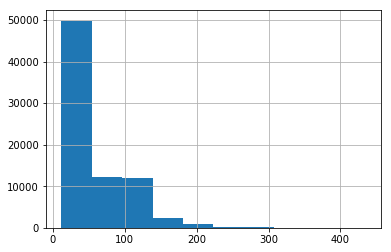

In [11]:
all_tracks["hailcast"]["area"].hist()

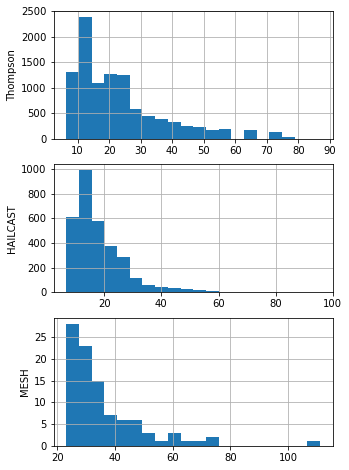

In [29]:
plt.figure(figsize=(5, 8))
plt.subplot(3, 1, 1)
mem_idx = all_tracks["thompson"]["Member"] == "wrf-core01_arw"
all_tracks["thompson"].loc[mem_idx, "hailk1_max"].hist(bins=20)
plt.ylabel("Thompson")
plt.subplot(3, 1, 2)
mem_idx = all_tracks["thompson"]["Member"] == "wrf-core01_arw"
all_tracks["hailcast"].loc[mem_idx, "hailsz_max"].hist(bins=20)
plt.ylabel("HAILCAST")
plt.subplot(3, 1, 3)
obs_tracks.loc[mem_idx, "MESH_max"].hist(bins=20)
plt.ylabel("MESH")

In [25]:
obs_tracks.columns

Index([u'Step_ID', u'Obs_Track_ID', u'Date', u'Forecast_Hour',
       u'Valid_Hour_UTC', u'Duration', u'Centroid_Lon', u'Centroid_Lat',
       u'MESH_mean', u'MESH_max', u'MESH_min', u'MESH_std',
       u'MESH_percentile_10', u'MESH_percentile_25', u'MESH_percentile_50',
       u'MESH_percentile_75', u'MESH_percentile_90', u'Run_Date'],
      dtype='object')

In [16]:
%matplotlib inline
def draw_hail_clusters(date, member, num_clusters):
    fig, axes = plt.subplots(3, 2, figsize=(8, 12))
    plt.subplots_adjust(0.02, 0.02, 0.98, 0.95, hspace=0.05)
    for ax in axes[:, 0]:
        bmap.drawstates(ax=ax)
        bmap.drawcoastlines(ax=ax)
        bmap.drawcountries(ax=ax)
    hc_idxs = np.where((all_tracks["hailcast"]["Run_Date"] == date) & 
                       (all_tracks["hailcast"]["Member"] == member))[0]
    th_idxs = np.where((all_tracks["thompson"]["Run_Date"] == date) & 
                       (all_tracks["thompson"]["Member"] == member))[0]
    ob_idxs = np.where(obs_tracks["Run_Date"] == date)[0]
    hc_size_order = np.argsort(all_tracks["hailcast"].loc[hc_idxs, "hailsz_max"])
    th_size_order = np.argsort(all_tracks["thompson"].loc[th_idxs, "hailk1_max"])
    ob_size_order = np.argsort(obs_tracks.loc[ob_idxs, "MESH_max"])
    #db_hc = DBSCAN(eps=1, min_samples=5)
    #db_th = DBSCAN(eps=1, min_samples=5)
    #db_me = DBSCAN(eps=1, min_samples=5)
    km_hc = AgglomerativeClustering(n_clusters=num_clusters, linkage="complete")
    km_th = AgglomerativeClustering(n_clusters=num_clusters, linkage="complete")
    km_me = AgglomerativeClustering(n_clusters=num_clusters, linkage="complete")
    cluster_cols = ["Centroid_Lon_n", "Centroid_Lat_n", "Forecast_Hour_n"]
    if len(hc_idxs) > 0:
        hc_clusters = km_hc.fit_predict(all_tracks["hailcast"].loc[hc_idxs, cluster_cols])
        print(silhouette_score(all_tracks["hailcast"].loc[hc_idxs, cluster_cols], hc_clusters))
    else:
        hc_clusters = np.array([])
    if len(th_idxs) > 0:
        th_clusters = km_th.fit_predict(all_tracks["thompson"].loc[th_idxs, cluster_cols])
        print(silhouette_score(all_tracks["thompson"].loc[th_idxs, cluster_cols], th_clusters))

    else:
        th_clusters = np.array([])
    if len(ob_idxs) > 0:
        me_clusters = km_me.fit_predict(obs_tracks.loc[ob_idxs, cluster_cols])
        print(silhouette_score(obs_tracks.loc[ob_idxs, cluster_cols], me_clusters))
    else:
        me_clusters = np.array([])
    axes[0, 0].scatter(all_tracks["hailcast"].loc[hc_idxs[hc_size_order], "Centroid_Lon"], 
                all_tracks["hailcast"].loc[hc_idxs[hc_size_order], "Centroid_Lat"], 10, 
                hc_clusters[hc_size_order],
                vmin=0, vmax=num_clusters - 1, cmap=plt.get_cmap("tab10", num_clusters))
    axes[0, 0].set(ylabel="HAILCAST")
    axes[0, 1].scatter(all_tracks["hailcast"].loc[hc_idxs[hc_size_order], "Centroid_Lon"],
                       all_tracks["hailcast"].loc[hc_idxs[hc_size_order], "Forecast_Hour"],
                      10,
                      hc_clusters[hc_size_order], 
                       vmin=0, vmax=num_clusters - 1, cmap=plt.get_cmap("tab10", num_clusters))
    axes[1, 0].scatter(all_tracks["thompson"].loc[th_idxs[th_size_order], "Centroid_Lon"], 
                    all_tracks["thompson"].loc[th_idxs[th_size_order], "Centroid_Lat"], 10, 
                    th_clusters[th_size_order],
                     vmin=0, vmax=num_clusters-1, cmap=plt.get_cmap("tab10", num_clusters))
    axes[1, 0].set(ylabel="Thompson")
    axes[1, 1].scatter(all_tracks["thompson"].loc[th_idxs[th_size_order], "Centroid_Lon"],
                       all_tracks["thompson"].loc[th_idxs[th_size_order], "Forecast_Hour"],
                      10,
                      th_clusters[th_size_order], 
                       vmin=0, vmax=num_clusters - 1, cmap=plt.get_cmap("tab10", num_clusters))
    axes[2, 0].scatter(obs_tracks.loc[ob_idxs[ob_size_order], "Centroid_Lon"], 
                    obs_tracks.loc[ob_idxs[ob_size_order], "Centroid_Lat"], 10, 
                    me_clusters[ob_size_order],
                     vmin=0, vmax=num_clusters-1, cmap=plt.get_cmap("tab10", num_clusters))
    axes[2, 0].set(ylabel="MESH")
    axes[0, 0].set_title(date)
    plt.show()
interact(draw_hail_clusters, 
         date=SelectionSlider(options=pd.DatetimeIndex(all_tracks["hailcast"]["Run_Date"]).unique().tolist()),
         member=SelectionSlider(options=members), num_clusters=SelectionSlider(options=list(range(2, 11))))

<function __main__.draw_hail_clusters>

In [23]:
caps_2016_config = pd.read_csv("../config/member_info_caps_spring2016.csv")
caps_2016_config

,Ensemble_Member,IC,BC,Microphysics,LSM,PBL,MicrophysicsTrue
0,wrf-core01_arw,00Z ARPSa,00Z NAMf,Thompson,Noah,MYJ,Thompson
1,wrf-core03_arw,arw_cn+em-p1_pert,21Z SREF em-p1,P3,Noah,YSU,P3
2,wrf-core04_arw,arw_cn+em-n2_pert,21Z SREF em-n2,MY,Noah,MYNN,MY
3,wrf-core05_arw,arw_cn+nmm-p1_pert,21Z SREF nmm-p1,Morrison,Noah,MYJ,Morrison
4,wrf-core06_arw,arw_cn+nmmb-n1_pert,21Z SREF nmmb-n1,P3,Noah,YSU,P3
5,wrf-core07_arw,arw_cn-nmmb_p1_pert,21Z SREF nmmb-p1,MY,Noah,MYNN,MY
6,wrf-core08_arw,arw_cn-em-n1_pert,21Z SREF em-n1,Morrison,Noah,YSU,Morrison
7,wrf-core09_arw,arw_cn-em-p2_pert,21Z SREF em-p2,P3,Noah,MYJ,P3
8,wrf-core10_arw,arw_cn-nmmb-n3_pert,21Z SREF nmmb-n3,Thompson,Noah,MYNN,Thompson


In [33]:
for col in all_tracks["thompson"].columns:
    print(col)

Step_ID
Track_ID
Date
Forecast_Hour
Valid_Hour_UTC
Duration
Centroid_Lon
Centroid_Lat
Storm_Motion_U
Storm_Motion_V
uh_max_mean
uh_max_max
uh_max_min
uh_max_std
uh_max_percentile_10
uh_max_percentile_25
uh_max_percentile_50
uh_max_percentile_75
uh_max_percentile_90
r10cmx_mean
r10cmx_max
r10cmx_min
r10cmx_std
r10cmx_percentile_10
r10cmx_percentile_25
r10cmx_percentile_50
r10cmx_percentile_75
r10cmx_percentile_90
wupmax_mean
wupmax_max
wupmax_min
wupmax_std
wupmax_percentile_10
wupmax_percentile_25
wupmax_percentile_50
wupmax_percentile_75
wupmax_percentile_90
cqgmax_mean
cqgmax_max
cqgmax_min
cqgmax_std
cqgmax_percentile_10
cqgmax_percentile_25
cqgmax_percentile_50
cqgmax_percentile_75
cqgmax_percentile_90
pwat_mean
pwat_max
pwat_min
pwat_std
pwat_percentile_10
pwat_percentile_25
pwat_percentile_50
pwat_percentile_75
pwat_percentile_90
wdnmax_mean
wdnmax_max
wdnmax_min
wdnmax_std
wdnmax_percentile_10
wdnmax_percentile_25
wdnmax_percentile_50
wdnmax_percentile_75
wdnmax_percentile_90
cm

dict_keys(['hailcast', 'thompson'])

In [ ]:
print("b")